
## 1. Project formulation
The goal of the project is to conduct a negative Bayesian and Poisson analysis of points scored by both teams in NBA game. This involves understanding the factors that influence game outcomes, such as team-specific offensive and defensive strengths, home-court advantage.

 By understanding and quantifying the factors that influence game outcomes, various stakeholders can benefit. Outcome can be highly useful for people involved in betting. It can also be useful for broadcasters and sports media by incorporating predictive analytics into pre-game and post-game analyses.

The data for 2022, 2023 seasons was scraped from official NBA website (www.nba.com/stats). After that, the duplicates were removed and data was sorted by date. Unique team IDs were created for better readibility in stan. Below is the representation of all columns in the prepared dataset:
1. start_time
2. away_team
3. away_team_score
4. home_team
5. home_team_score
6. home_team_id
7. away_team_id

Confoudings
1. Pipes

home_team_score -> home_score_pred

home_team_score -> away_def -> away_score_pred

away_team_score -> away_score_pred

away_team_score -> home_def -> home_score_pred

2. Forks

home_team_score influences home_score_pred and away_score_pred

away_team_score influences away_score_pred and home_score_pred

3. Colliders

None

## DAG

phi_home and phi_away was included in negative binomial model additionally.

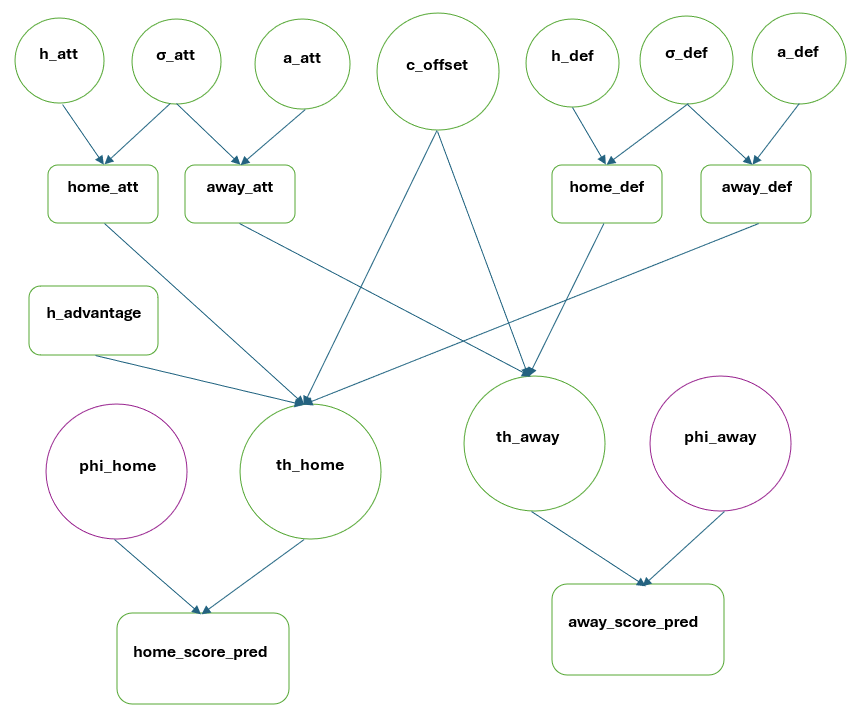

In [7]:
from PIL import Image
from IPython.display import display
DAG = Image.open('DAG.png')
display(DAG)

In [8]:
import os

from cmdstanpy import CmdStanModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import nbinom, norm, poisson, gamma
import arviz as az
import warnings

# Ignore user warnings
warnings.filterwarnings('ignore', category=UserWarning)

os.chdir('/app')

from src.web_scraping.scraper import scrap_games

Input parameters for scraping

In [9]:
years = list(range(2022, 2024))
train_year = years[0]
pred_year = years[1]

Scraping

In [10]:
scrap_games(years)

Read data

Preprocessing: the duplicates were removed and data was sorted by date. Next step of preprocessing is to check whether outliers occurs

In [11]:
path = 'src/data/'
path_games = os.path.join(path, 'games/')
seasons_games = {}

# prepare dataframes - drop duplicated rows and sort by date
for year in years:
    seasons_games[year] = pd.read_csv(os.path.join(path_games, f'{year-1}_{year}_season.csv')).drop_duplicates().sort_values(by='start_time').reset_index(drop=True)

    # search for missing values
    missing_values = seasons_games[year].isnull().sum()
    print(missing_values)
    
    # invalid scores
    invalid_scores = seasons_games[year][(seasons_games[year]['home_team_score'] < 40) 
                                         | (seasons_games[year]['home_team_score'] > 200)
                                         | (seasons_games[year]['away_team_score'] < 40)
                                         | (seasons_games[year]['away_team_score'] > 200)
                                         ]
    print(invalid_scores)

start_time         0
away_team          0
away_team_score    0
home_team          0
home_team_score    0
dtype: int64
Empty DataFrame
Columns: [start_time, away_team, away_team_score, home_team, home_team_score]
Index: []
start_time         0
away_team          0
away_team_score    0
home_team          0
home_team_score    0
dtype: int64
Empty DataFrame
Columns: [start_time, away_team, away_team_score, home_team, home_team_score]
Index: []


Edit dataframe

In [12]:
# get unique team names
teams = list(seasons_games[train_year]['home_team'].unique())

# map team to id
team_to_id = {team: i + 1 for i, team in enumerate(teams)}

for year in years:
    # Add IDs of teams to be differentiate for stan
    seasons_games[year]['home_team_id'] = seasons_games[year]['home_team'].map(team_to_id)
    seasons_games[year]['away_team_id'] = seasons_games[year]['away_team'].map(team_to_id)

    # Add difference in points between home team and away team
    for year in years:
        seasons_games[year]['difference'] = seasons_games[year]['home_team_score'] - seasons_games[year]['away_team_score']

Show data (first 5 rows)

In [13]:
for year in years:
    print(seasons_games[year].head())

                  start_time              away_team  away_team_score  \
0  2021-10-19 23:30:00+00:00          BROOKLYN NETS              104   
1  2021-10-20 02:00:00+00:00  GOLDEN STATE WARRIORS              121   
2  2021-10-20 23:00:00+00:00         INDIANA PACERS              122   
3  2021-10-20 23:00:00+00:00          CHICAGO BULLS               94   
4  2021-10-20 23:30:00+00:00         BOSTON CELTICS              134   

            home_team  home_team_score  home_team_id  away_team_id  difference  
0     MILWAUKEE BUCKS              127             1            28          23  
1  LOS ANGELES LAKERS              114             2            16          -7  
2   CHARLOTTE HORNETS              123             3            26           1  
3     DETROIT PISTONS               88             4            23          -6  
4     NEW YORK KNICKS              138             5            21           4  
                  start_time           away_team  away_team_score  \
0  2022-10-1

Plot data

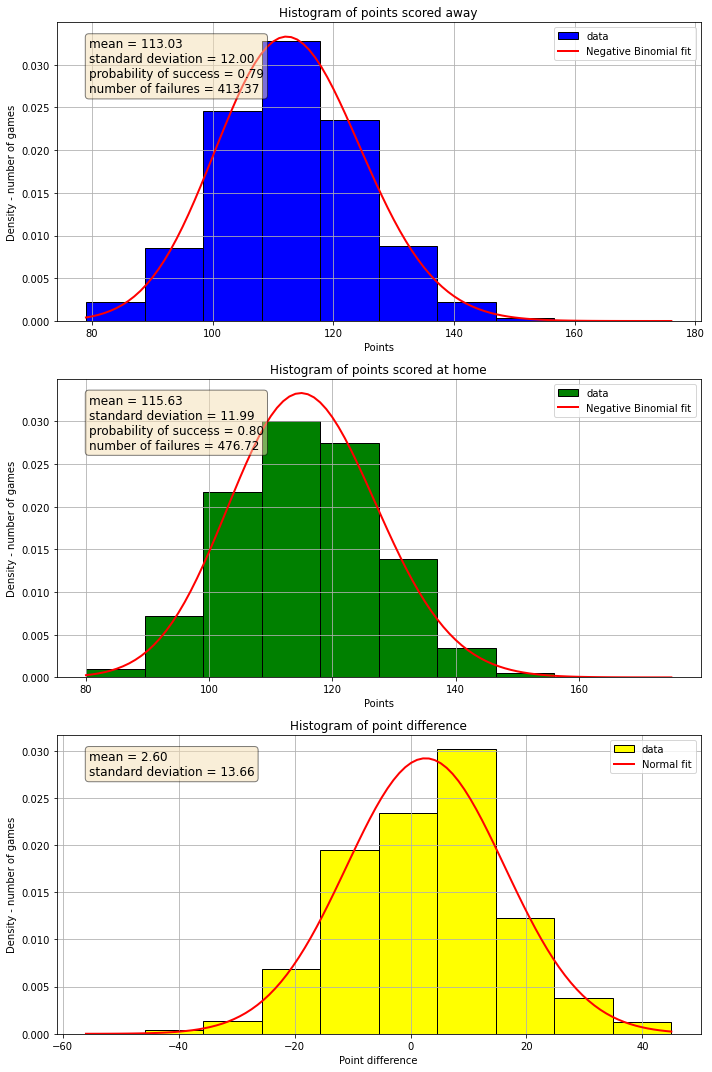

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=10, color='blue', edgecolor='black', label='data')
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=10, color='green', edgecolor='black', label='data')
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

# Histogram of point difference
axes[2].hist(seasons_games[year]['difference'], density=True, bins=10, color='yellow', edgecolor='black', label='data')
axes[2].set_title('Histogram of point difference')
axes[2].set_xlabel('Point difference')
axes[2].set_ylabel('Density - number of games')

# Plot the negative binomial PDF on each chart
for ax, col in zip(axes, ('away_team_score', 'home_team_score', 'difference')):
    mean, var = np.mean(seasons_games[year][col]), np.var(seasons_games[year][col])
    std = np.sqrt(var)
    if col == 'difference':
        x = np.linspace(min(seasons_games[year][col]), max(seasons_games[year][col]), 100)
        normal_pdf = norm.pdf(x, mean, std)
    
        # Plot the normal PDF
        ax.plot(x, normal_pdf, 'r-', lw=2, label='Normal fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    else:
        p = mean / var
        r = mean ** 2 / (var - mean)  # Number of failures
        x = np.arange(min(seasons_games[year][col]), max(seasons_games[year][col]) + 1)
        nbinom_pmf = nbinom.pmf(x, r, p)
            
        # Plot the negative binomial PDF
        ax.plot(x, nbinom_pmf, 'r-', lw=2, label='Negative Binomial fit')
        
        textstr = f'mean = {mean:.2f}\nstandard deviation = {std:.2f}\nprobability of success = {p:.2f}\nnumber of failures = {r:.2f}'
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox={'boxstyle': 'round', 'facecolor': 'wheat', 'alpha': 0.5})
    ax.legend()
    ax.grid()

plt.tight_layout()

Prepare input data

In [15]:
inp_data = {
    'teams_number': len(teams),
    'games_number': len(seasons_games[train_year]),
    'home_team': seasons_games[train_year].home_team_id.to_numpy(),
    'away_team': seasons_games[train_year].away_team_id.to_numpy(),
    'home_score': seasons_games[train_year].home_team_score.to_numpy(),
    'away_score': seasons_games[train_year].away_team_score.to_numpy(),
}

# 2. Evaluation of Poisson and Negative Binomial Models

The primary distinction lies in the flexibility of the Negative Binomial model, which introduces an additional parameter compared to the Poisson model. This additional parameter allows the Negative Binomial model to better accommodate the variability in the data, leading to improved predictive accuracy.

Negative Binomial provides a better fit for the data due to its ability to handle overdispersion, which is a common characteristic in sports data where the variance exceeds the mean. Negative Binomial model consistently outperforms the Poisson model in terms of predictive accuracy.

The Poisson model is described by a single parameter (λ), representing the mean number of events, while the Negative Binomial model introduces an additional parameter (r), which accounts for the overdispersion. The data required for these models include the observed counts of events, such as scores in basketball games, along with other covariates that may influence the outcome.

Prior parameters were chosen experimentally based on domain knowledge to reflect realistic assumptions about the data. Home offensive and defensive strength is respectively higher, reflecting the expectation that home teams generally have slight advantage in offense.

## MODEL 1 Negative Binomial

### Prior

In [16]:
model_nbinomial_prior = CmdStanModel(stan_file='src/model/model_nbinomial_prior.stan')
samples = 1000
sim_nbin_prior=model_nbinomial_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [17]:
mod_nbin_prior = sim_nbin_prior.draws_pd()
print(mod_nbin_prior.head())

   lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0   0.0            0.0             33.0            632.0    -0.000488   
1   0.0            0.0            633.0              0.0    -0.000328   
2   0.0            0.0             41.0            146.0    -0.001546   
3   0.0            0.0            126.0           1550.0     0.000703   
4   0.0            0.0             27.0            103.0     0.001024   

   mu_away_att  mu_home_def  mu_away_def  sigma_att  sigma_def  ...  \
0     0.000215    -0.000708    -0.002356   1.165640   0.272082  ...   
1    -0.001611    -0.001009     0.000010  18.240400   1.188750  ...   
2    -0.000114    -0.000266    -0.002262   0.856358   0.212118  ...   
3     0.000396    -0.000942    -0.000966   1.742800   0.000016  ...   
4    -0.001071     0.001216     0.001355   0.110633   0.529087  ...   

   home_advantage  c_offset  phi_home  phi_away  mu_home  mu_away  home_att  \
0        0.107750   4.43980   199.381   210.688      Na

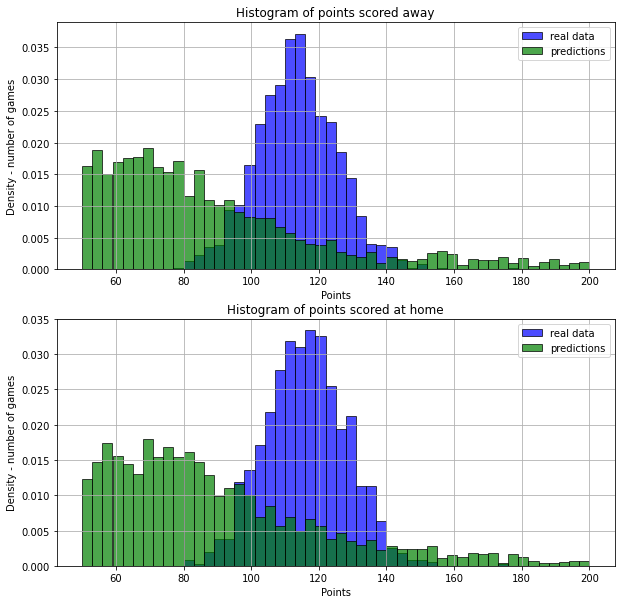

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[0].hist(sim_nbin_prior.stan_variable('away_score_pred'), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')
axes[0].legend()
axes[0].grid()

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[1].hist(sim_nbin_prior.stan_variable('home_score_pred'), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')
axes[1].legend()
axes[1].grid()

### Posterior

In [19]:
model_nbinomial_post = CmdStanModel(stan_file='src/model/model_nbinomial_posterior.stan')
samples = 1000
sim_nbinomial_post=model_nbinomial_post.sample(data=inp_data,
                     iter_sampling=samples,
                     chains=4
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_nbinomial_posterior.stan to exe file /app/src/model/model_nbinomial_posterior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_nbinomial_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▉         | 00:13 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:22 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:29 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:34 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:39 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:42 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:47 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:50 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:53 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:55 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉ 


INFO:cmdstanpy:CmdStan done processing.


In [20]:
mod_nbin_post = sim_nbinomial_post.draws_pd()
print(mod_nbin_post)

         lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0    -8216.25       0.792103    0.265431          4.0          15.0   
1    -8231.18       0.661983    0.265431          4.0          15.0   
2    -8226.73       0.965752    0.265431          4.0          15.0   
3    -8220.77       0.966120    0.265431          4.0          15.0   
4    -8220.41       0.935414    0.265431          4.0          15.0   
...       ...            ...         ...          ...           ...   
3995 -8232.08       0.663066    0.268188          4.0          15.0   
3996 -8226.78       0.922168    0.268188          4.0          15.0   
3997 -8225.47       0.868141    0.268188          4.0          15.0   
3998 -8235.14       0.559913    0.268188          4.0          15.0   
3999 -8244.83       0.824176    0.268188          4.0          15.0   

      divergent__  energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             0.0   8282.00     0.000292    -0.001135    -0.000305  ... 

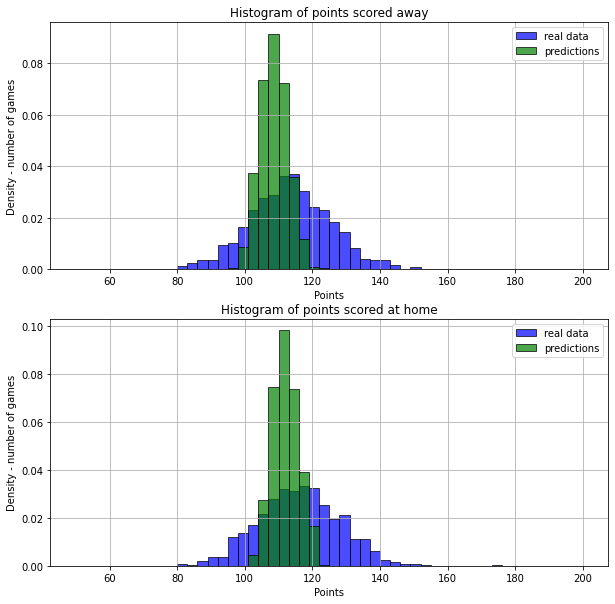

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[0].hist(sim_nbinomial_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')
axes[0].legend()
axes[0].grid()

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[1].hist(sim_nbinomial_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')
axes[1].legend()
axes[1].grid()

In [22]:
for team, idx in team_to_id.items():
    print(idx, ':   ', team, sep='')

1:   MILWAUKEE BUCKS
2:   LOS ANGELES LAKERS
3:   CHARLOTTE HORNETS
4:   DETROIT PISTONS
5:   NEW YORK KNICKS
6:   TORONTO RAPTORS
7:   MEMPHIS GRIZZLIES
8:   MINNESOTA TIMBERWOLVES
9:   NEW ORLEANS PELICANS
10:   SAN ANTONIO SPURS
11:   UTAH JAZZ
12:   PORTLAND TRAIL BLAZERS
13:   PHOENIX SUNS
14:   ATLANTA HAWKS
15:   MIAMI HEAT
16:   GOLDEN STATE WARRIORS
17:   ORLANDO MAGIC
18:   WASHINGTON WIZARDS
19:   CLEVELAND CAVALIERS
20:   PHILADELPHIA 76ERS
21:   BOSTON CELTICS
22:   HOUSTON ROCKETS
23:   CHICAGO BULLS
24:   DENVER NUGGETS
25:   SACRAMENTO KINGS
26:   INDIANA PACERS
27:   LOS ANGELES CLIPPERS
28:   BROOKLYN NETS
29:   OKLAHOMA CITY THUNDER
30:   DALLAS MAVERICKS


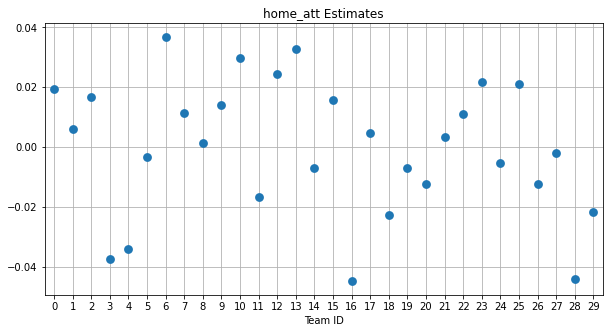

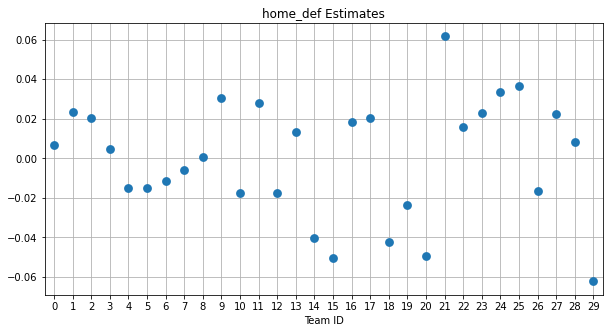

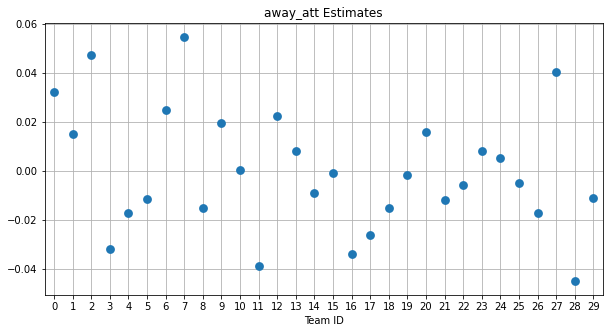

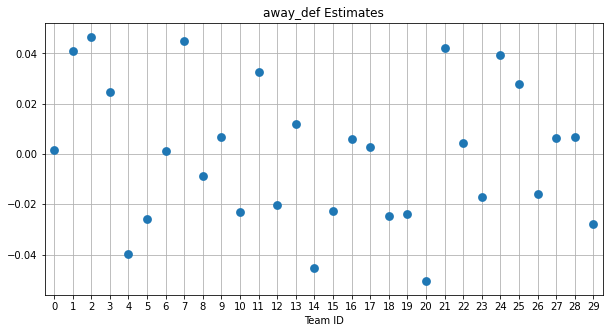

In [23]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']

for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.pointplot(data=sim_nbinomial_post.stan_variable(param), ax=ax, join=False)
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    ax.grid()
    plt.show()

## Model 2 - Poisson

### Prior

In [24]:
model_poiss_prior = CmdStanModel(stan_file='src/model/model_poisson_prior.stan')
samples = 1000
sim_poiss_prior=model_poiss_prior.sample(iter_sampling=samples)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [25]:
mod_poiss_prio = sim_poiss_prior.draws_pd()
print(mod_poiss_prio)

      lp__  accept_stat__  home_score_pred  away_score_pred  mu_home_att  \
0      0.0            0.0             57.0             77.0     0.000408   
1      0.0            0.0              NaN              NaN          NaN   
2      0.0            0.0             61.0             57.0    -0.000492   
3      0.0            0.0              4.0              8.0    -0.001165   
4      0.0            0.0             66.0             43.0     0.000250   
...    ...            ...              ...              ...          ...   
3995   0.0            0.0             54.0             19.0    -0.000217   
3996   0.0            0.0             55.0             32.0     0.001154   
3997   0.0            0.0           1152.0            615.0    -0.000121   
3998   0.0            0.0             62.0             56.0     0.001229   
3999   0.0            0.0             89.0             74.0    -0.000398   

      mu_away_att  mu_home_def  mu_away_def  sigma_att  sigma_def  theta_home  \
0     

Text(0, 0.5, 'Density - number of games')

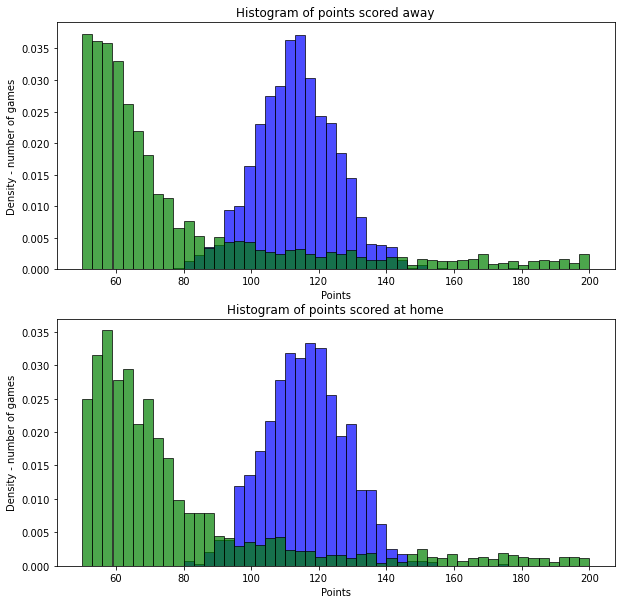

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[0].hist(sim_poiss_prior.stan_variable('away_score_pred'), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[1].hist(sim_poiss_prior.stan_variable('home_score_pred'), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

### Posterior

In [27]:
model_poiss_post = CmdStanModel(stan_file='src/model/model_poisson_posterior.stan')
samples = 1000
sim_poiss_post=model_poiss_post.sample(data=inp_data,
                     iter_sampling=samples,
                     chains=4
                     )

INFO:cmdstanpy:compiling stan file /app/src/model/model_poisson_posterior.stan to exe file /app/src/model/model_poisson_posterior
INFO:cmdstanpy:compiled model executable: /app/src/model/model_poisson_posterior
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |▉         | 00:03 Iteration:    1 / 2000 [  0%]  (Warmup)




chain 1 |█▎        | 00:06 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:07 Iteration:  200 / 2000 [ 10%]  (Warmup)
chain 1 |██▎       | 00:09 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:10 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:11 Iteration:  500 / 2000 [ 25%]  (Warmup)

chain 1 |███▋      | 00:12 Iteration:  600 / 2000 [ 30%]  (Warmup)



chain 1 |████      | 00:13 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:14 Iteration:  900 / 2000 [ 45%


INFO:cmdstanpy:CmdStan done processing.


In [28]:
mod_poiss_post = sim_poiss_post.draws_pd()
print(mod_poiss_post)

           lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0     1081660.0       0.912346    0.254967          4.0          15.0   
1     1081660.0       0.803124    0.254967          4.0          15.0   
2     1081660.0       0.972012    0.254967          4.0          15.0   
3     1081670.0       0.969500    0.254967          4.0          15.0   
4     1081670.0       0.801510    0.254967          4.0          15.0   
...         ...            ...         ...          ...           ...   
3995  1081670.0       0.768424    0.244192          4.0          15.0   
3996  1081660.0       0.760885    0.244192          4.0          15.0   
3997  1081670.0       0.869638    0.244192          4.0          15.0   
3998  1081660.0       0.789936    0.244192          4.0          15.0   
3999  1081650.0       0.696135    0.244192          4.0          15.0   

      divergent__   energy__  mu_home_att  mu_away_att  mu_home_def  ...  \
0             0.0 -1081600.0     0.001494    -0

Text(0, 0.5, 'Density - number of games')

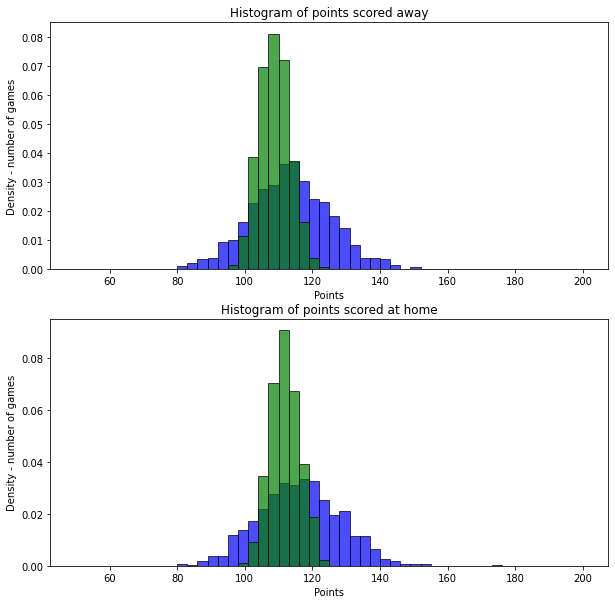

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[year]['away_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[0].hist(sim_poiss_post.stan_variable('away_score_pred').mean(axis=0), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')

# Histogram of points scored at home
axes[1].hist(seasons_games[year]['home_team_score'], density=True, bins=50, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[1].hist(sim_poiss_post.stan_variable('home_score_pred').mean(axis=0), density=True, bins=50, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')

In [30]:
for team, idx in team_to_id.items():
    print(idx, ':   ', team, sep='')

1:   MILWAUKEE BUCKS
2:   LOS ANGELES LAKERS
3:   CHARLOTTE HORNETS
4:   DETROIT PISTONS
5:   NEW YORK KNICKS
6:   TORONTO RAPTORS
7:   MEMPHIS GRIZZLIES
8:   MINNESOTA TIMBERWOLVES
9:   NEW ORLEANS PELICANS
10:   SAN ANTONIO SPURS
11:   UTAH JAZZ
12:   PORTLAND TRAIL BLAZERS
13:   PHOENIX SUNS
14:   ATLANTA HAWKS
15:   MIAMI HEAT
16:   GOLDEN STATE WARRIORS
17:   ORLANDO MAGIC
18:   WASHINGTON WIZARDS
19:   CLEVELAND CAVALIERS
20:   PHILADELPHIA 76ERS
21:   BOSTON CELTICS
22:   HOUSTON ROCKETS
23:   CHICAGO BULLS
24:   DENVER NUGGETS
25:   SACRAMENTO KINGS
26:   INDIANA PACERS
27:   LOS ANGELES CLIPPERS
28:   BROOKLYN NETS
29:   OKLAHOMA CITY THUNDER
30:   DALLAS MAVERICKS


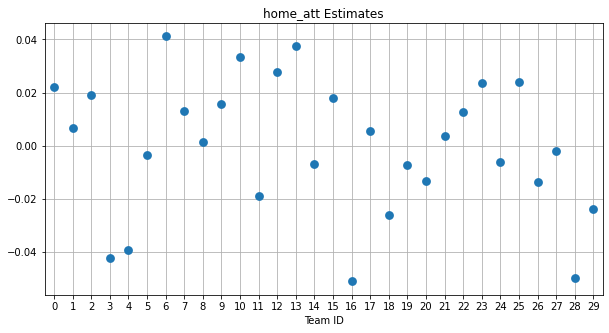

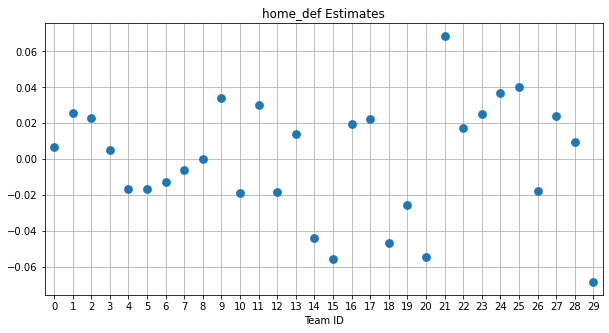

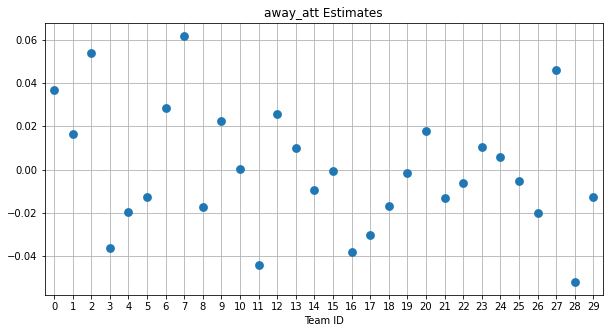

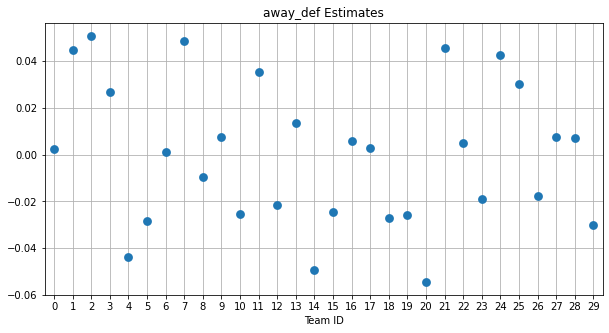

In [31]:
parameters = ['home_att', 'home_def', 'away_att', 'away_def']

for param in parameters:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.pointplot(data=sim_poiss_post.stan_variable(param), ax=ax, join=False)
    ax.set_xticks(range(len(teams)))
    ax.set_title(f'{param} Estimates')
    ax.set_xlabel('Team ID')
    ax.grid()
    plt.show()

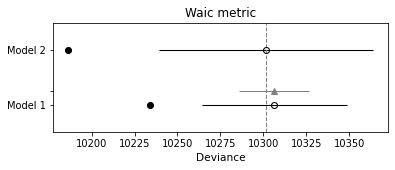

In [32]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nbinomial_post, log_likelihood={"home": "log_lik_home"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"home": "log_lik_home"})

# Comparing models
comp_dict = {'Model 1': idata_nbin, "Model 2": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

In [33]:
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 2,0,10301.494340,57.507395,0.000000,0.589099,62.267336,0.000000,True,deviance
Model 1,1,10306.342786,36.308952,4.848446,0.410901,42.237849,20.242767,False,deviance


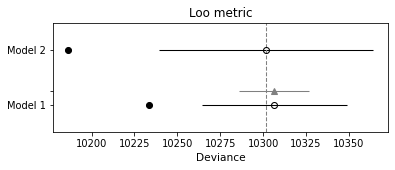

In [34]:
comp_loo = az.compare(comp_dict, ic='loo', scale='deviance')
az.plot_compare(comp_loo)
plt.title("Loo metric")
plt.show()

In [35]:
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 2,0,10301.653844,57.587147,0.000000,0.588712,62.274043,0.000000,False,deviance
Model 1,1,10306.421572,36.348345,4.767728,0.411288,42.240277,20.247031,False,deviance


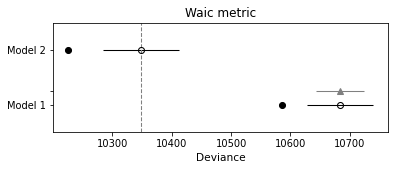

In [36]:
idata_nbin = az.from_cmdstanpy(posterior=sim_nbinomial_post, log_likelihood={"away": "log_lik_away"})
idata_poisson = az.from_cmdstanpy(posterior=sim_poiss_post, log_likelihood={"away": "log_lik_away"})

# Comparing models
comp_dict = {'Model 1': idata_nbin, "Model 2": idata_poisson}

comp_waic = az.compare(comp_dict, ic='waic', scale='deviance')
az.plot_compare(comp_waic)
plt.title("Waic metric")
plt.show()

In [37]:
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Model 2,0,10347.993712,61.059822,0.000000,0.904545,64.488491,0.000000,True,deviance
Model 1,1,10683.160810,48.416230,335.167098,0.095455,55.532422,40.740288,True,deviance


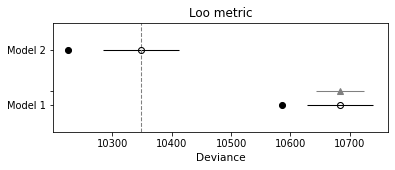

In [38]:
comp_loo = az.compare(comp_dict, ic='loo', scale='deviance')
az.plot_compare(comp_loo)
plt.title("Loo metric")
plt.show()

In [39]:
comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Model 2,0,10348.138195,61.132064,0.000000,0.904492,64.490948,0.000000,False,deviance
Model 1,1,10683.267621,48.469635,335.129426,0.095508,55.536296,40.742181,False,deviance


# 3. Model comparision

### Results for loo criterion

When comparing models using the Loo criterion, an error occurred 

Clear Winner: Poisson model is the clear winner with a significantly lower WAIC score, indicating better predictive accuracy compared to Negative Binomial model.

Overlap: The substantial difference in LOO scores clearly favors Poisson model, with no significant overlap.

Warnings: The warning suggests that Negative Binomial model may not be robust. Non-robust models are more sensitive to individual observations, and making LOO estimates less reliable.

### Results for waic criterion
Clear Winner: Poisson model is the clear winner with a significantly lower WAIC score, indicating better predictive accuracy compared to Negative Binomail model.

Overlap: Given the large difference in WAIC scores, there is no overlap, clearly favoring Poisson model.

Warnings: The warning for Poisson model suggests some issues with WAIC calculation, indicating that the posterior variance of the log predictive densities exceeds 0.4. This means that while Poisson model has a better WAIC score, caution is needed in interpreting this result, and further validation might be necessary.

## Predicting game results

### Poisson

In [40]:
model = 'poisson'
if model == 'poisson':
    parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'c_offset', 'home_advantage']
elif model == 'NB':
    parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'phi_home', 'phi_away', 'c_offset', 'home_advantage']
param_dict = {param: sim_poiss_post.stan_variable(param) for param in parameters}
# for key, val in param_dict.items():
#     print(key, val.shape)

# Extracting the samples that we need
def predict(row):
    # print(row)
    # print(type(row))
    home_idx = row['home_team_id'] - 1
    away_idx = row['away_team_id'] - 1
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    c_offset = param_dict['c_offset']
    home_advantage = param_dict['home_advantage']
    
    if model == 'NB':
        phi_home = param_dict['phi_home']
        phi_away = param_dict['phi_away']
    
    theta_home_pred = np.exp(home_att + away_def + c_offset + home_advantage)
    theta_away_pred = np.exp(away_att + home_def + c_offset)
    
    if model == 'NB':
        home_score_pred = np.random.negative_binomial(phi_home, phi_home / (theta_home_pred + phi_home))
        away_score_pred = np.random.negative_binomial(phi_away, phi_away / (theta_away_pred + phi_away))
    elif model == 'poisson':
        home_score_pred = np.random.poisson(theta_home_pred)
        away_score_pred = np.random.poisson(theta_away_pred)
    
    for i in range(len(home_score_pred)):
        if home_score_pred[i] == away_score_pred[i]:
            point = 1 if np.random.rand() > 0.5 else -1
            if np.random.rand() > 0.5:
                home_score_pred[i] += point
            else:
                away_score_pred[i] += point
    
    home_points_difference = row['home_team_score'] - home_score_pred
    away_points_difference = row['away_team_score'] - away_score_pred
    
    # print(np.mean(y1 > y2), np.mean(y1 == y2), np.mean(y1 < y2))
    # print(np.mean(y1 > y2) + np.mean(y1 == y2) + np.mean(y1 < y2))

    return pd.Series({
            'home_team_win_prob': np.mean(home_score_pred > away_score_pred),
            'away_team_win_prob': np.mean(home_score_pred < away_score_pred),
            'mean_home_score': np.mean(home_score_pred),
            'mean_away_score': np.mean(away_score_pred),
            'std_home_score': np.std(home_score_pred),
            'std_away_score': np.std(away_score_pred),
            'mean_home_points_difference': np.mean(home_points_difference),
            'mean_away_points_difference': np.mean(away_points_difference),
            'std_home_points_difference': np.std(home_points_difference),
            'std_away_points_difference': np.std(away_points_difference),
            'is_win_team_predicted': np.mean(home_score_pred > away_score_pred) > 0.5 and row['home_team_score'] > row['away_team_score'] or
                                        np.mean(home_score_pred < away_score_pred) > 0.5 and row['home_team_score'] < row['away_team_score']
    })
    
seasons_games[pred_year][['home_team_win_prob', 
                          'away_team_win_prob', 
                          'mean_home_score',
                          'mean_away_score',
                          'std_home_score',
                          'std_away_score',
                          'mean_home_points_difference',
                          'mean_away_points_difference',
                          'std_home_points_difference',
                          'std_away_points_difference',
                          'is_win_team_predicted']] = seasons_games[pred_year].apply(predict, axis=1)

accurracy = np.mean(seasons_games[pred_year]['is_win_team_predicted'])
print("Accuracy: ", accurracy)

Accuracy:  0.5598484848484848


Text(0.5, 1.0, 'Difference between real and predicted amount of points')

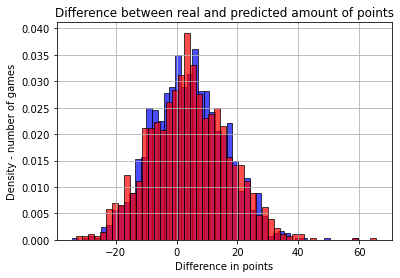

In [41]:
plt.hist(seasons_games[pred_year]['mean_home_points_difference'], density=True, bins=50, color='blue', edgecolor='black', alpha=0.7, label='home points')
plt.hist(seasons_games[pred_year]['mean_away_points_difference'], density=True, bins=50, color='red', edgecolor='black', alpha=0.7, label='away points')
plt.grid()
plt.xlabel('Difference in points')
plt.ylabel('Density - number of games')
plt.title('Difference between real and predicted amount of points')

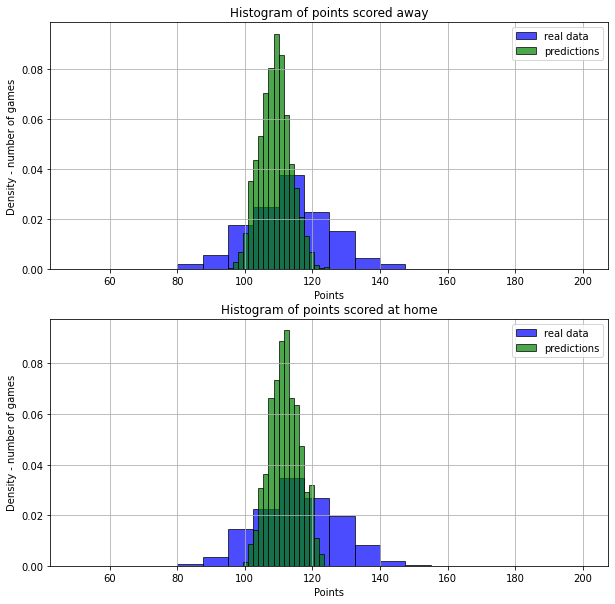

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[pred_year]['away_team_score'], density=True, bins=20, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[0].hist(seasons_games[pred_year]['mean_away_score'], density=True, bins=100, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')
axes[0].legend()
axes[0].grid()

# Histogram of points scored at home
axes[1].hist(seasons_games[pred_year]['home_team_score'], density=True, bins=20, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[1].hist(seasons_games[pred_year]['mean_home_score'], density=True, bins=100, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')
axes[1].legend()
axes[1].grid()

### Negative Binomial

In [43]:
model = 'NB'
if model == 'poisson':
    parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'c_offset', 'home_advantage']
elif model == 'NB':
    parameters = ['home_att', 'home_def', 'away_att', 'away_def', 'phi_home', 'phi_away', 'c_offset', 'home_advantage']
param_dict = {param: sim_nbinomial_post.stan_variable(param) for param in parameters}
# for key, val in param_dict.items():
#     print(key, val.shape)

# Extracting the samples that we need
def predict(row):
    # print(row)
    # print(type(row))
    home_idx = row['home_team_id'] - 1
    away_idx = row['away_team_id'] - 1
    home_att = param_dict['home_att'][:, home_idx]
    home_def = param_dict['home_def'][:, away_idx]
    away_att = param_dict['away_att'][:, home_idx]
    away_def = param_dict['away_def'][:, away_idx]
    c_offset = param_dict['c_offset']
    home_advantage = param_dict['home_advantage']
    
    if model == 'NB':
        phi_home = param_dict['phi_home']
        phi_away = param_dict['phi_away']
    
    theta_home_pred = np.exp(home_att + away_def + c_offset + home_advantage)
    theta_away_pred = np.exp(away_att + home_def + c_offset)
    
    if model == 'NB':
        home_score_pred = np.random.negative_binomial(phi_home, phi_home / (theta_home_pred + phi_home))
        away_score_pred = np.random.negative_binomial(phi_away, phi_away / (theta_away_pred + phi_away))
    elif model == 'poisson':
        home_score_pred = np.random.poisson(theta_home_pred)
        away_score_pred = np.random.poisson(theta_away_pred)
    
    for i in range(len(home_score_pred)):
        if home_score_pred[i] == away_score_pred[i]:
            point = 1 if np.random.rand() > 0.5 else -1
            if np.random.rand() > 0.5:
                home_score_pred[i] += point
            else:
                away_score_pred[i] += point
    
    home_points_difference = row['home_team_score'] - home_score_pred
    away_points_difference = row['away_team_score'] - away_score_pred
    
    # print(np.mean(y1 > y2), np.mean(y1 == y2), np.mean(y1 < y2))
    # print(np.mean(y1 > y2) + np.mean(y1 == y2) + np.mean(y1 < y2))

    return pd.Series({
            'home_team_win_prob': np.mean(home_score_pred > away_score_pred),
            'away_team_win_prob': np.mean(home_score_pred < away_score_pred),
            'mean_home_score': np.mean(home_score_pred),
            'mean_away_score': np.mean(away_score_pred),
            'std_home_score': np.std(home_score_pred),
            'std_away_score': np.std(away_score_pred),
            'mean_home_points_difference': np.mean(home_points_difference),
            'mean_away_points_difference': np.mean(away_points_difference),
            'std_home_points_difference': np.std(home_points_difference),
            'std_away_points_difference': np.std(away_points_difference),
            'is_win_team_predicted': np.mean(home_score_pred > away_score_pred) > 0.5 and row['home_team_score'] > row['away_team_score'] or
                                        np.mean(home_score_pred < away_score_pred) > 0.5 and row['home_team_score'] < row['away_team_score']
    })
    
seasons_games[pred_year][['home_team_win_prob', 
                          'away_team_win_prob', 
                          'mean_home_score',
                          'mean_away_score',
                          'std_home_score',
                          'std_away_score',
                          'mean_home_points_difference',
                          'mean_away_points_difference',
                          'std_home_points_difference',
                          'std_away_points_difference',
                          'is_win_team_predicted']] = seasons_games[pred_year].apply(predict, axis=1)

accurracy = np.mean(seasons_games[pred_year]['is_win_team_predicted'])
print("Accuracy:", accurracy)
print("Mean standard deviation of predicted home points:", np.mean(seasons_games[pred_year]['std_home_points_difference']))
print("Mean standard deviation of predicted away points:", np.mean(seasons_games[pred_year]['std_away_points_difference']))

Accuracy: 0.5704545454545454
Mean standard deviation of predicted home points: 13.07894761462771
Mean standard deviation of predicted away points: 12.866924214410993


Text(0.5, 1.0, 'Difference between real and predicted amount of points')

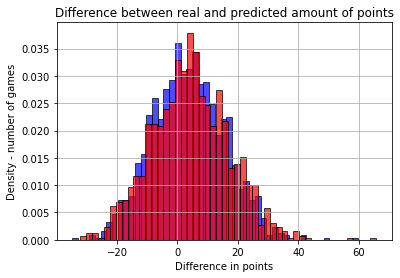

In [44]:
plt.hist(seasons_games[pred_year]['mean_home_points_difference'], density=True, bins=50, color='blue', edgecolor='black', alpha=0.7, label='home points')
plt.hist(seasons_games[pred_year]['mean_away_points_difference'], density=True, bins=50, color='red', edgecolor='black', alpha=0.7, label='away points')
plt.grid()
plt.xlabel('Difference in points')
plt.ylabel('Density - number of games')
plt.title('Difference between real and predicted amount of points')

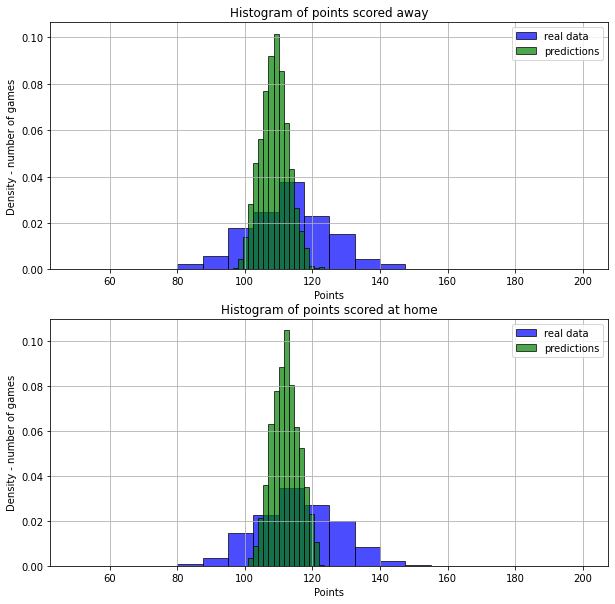

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

# Histogram of points scored away
axes[0].hist(seasons_games[pred_year]['away_team_score'], density=True, bins=20, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[0].hist(seasons_games[pred_year]['mean_away_score'], density=True, bins=100, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[0].set_title('Histogram of points scored away')
axes[0].set_xlabel('Points')
axes[0].set_ylabel('Density - number of games')
axes[0].legend()
axes[0].grid()

# Histogram of points scored at home
axes[1].hist(seasons_games[pred_year]['home_team_score'], density=True, bins=20, alpha=0.7, color='blue', edgecolor='black', label='real data', range=(50, 200))
axes[1].hist(seasons_games[pred_year]['mean_home_score'], density=True, bins=100, alpha=0.7, color='green', edgecolor='black', label='predictions', range=(50, 200))
axes[1].set_title('Histogram of points scored at home')
axes[1].set_xlabel('Points')
axes[1].set_ylabel('Density - number of games')
axes[1].legend()
axes[1].grid()

# 4. Conclusions
The Poisson model demonstrated better performance in simulating the number of points scored in a game, fits the data better and has lower complexity, making it more efficient for predicting points. On the other hand, the Negative Binomial model showed slightly better performance in predicting the game winner. The Negative Binomial model handles overdispersion in the data better, which can translate to more accurate binary outcome predictions, such as win or loss.
It is worth noting, that accuracy of predicting winning team can be that low because model predictors are amount of points scored by home team and away team, not which team won the game. In such case, the mean difference between real amount of points and predicted should be considered as metric to evaluate model.